In [1]:
# import networkx as nx
# import networkx.algorithms.community as nx_comm
# import matplotlib
# import matplotlib.pyplot as plt
# import matplotlib.ticker as mtick
# 
# import pandas as pd
# import seaborn as sns
# import numpy as np
# from pysankey import sankey

# %matplotlib inline

# matplotlib.use("pgf")
# sns.set_theme(style='white')
# plt.rcParams["axes.linewidth"] = 0.5
# plt.rcParams["legend.fontsize"] = 6.5
# plt.rcParams["xtick.labelsize"] = 8
# plt.rcParams["ytick.labelsize"] = 8
# plt.rcParams["ytick.left"] = True
# plt.rcParams['ytick.major.size'] = 5
# plt.rcParams['ytick.major.width'] = 0.5
# plt.rcParams['ytick.major.pad'] = 0
# plt.rcParams["xtick.bottom"] = True
# plt.rcParams['xtick.major.size'] = 5
# plt.rcParams['xtick.major.width'] = 0.5
# plt.rcParams['xtick.major.pad'] = 0
# plt.rcParams["pgf.texsystem"] = "pdflatex"
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["text.usetex"] = True
# plt.rcParams["pgf.rcfonts"] = False
# plt.rcParams["axes.titlesize"] = 8
# plt.rcParams["legend.handletextpad"] = 0.3
# plt.rcParams['lines.markersize'] = 4
# plt.rcParams['savefig.pad_inches'] = 0.01
# 

#plt.style.use("seaborn-whitegrid")
#sns.set_palette("deep")
#sns.set_context("notebook")  # Set to "paper" for use in paper :)

#plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import matplotlib.pyplot as plt

from sec_certs.dataset.fips import FIPSDataset
from collections import Counter
from pprint import pprint

# Typing imports
from pandas.core.frame import DataFrame
from typing import Callable

sns.set_palette("deep")

In [3]:
dset = FIPSDataset.from_web_latest()

In [4]:
df = dset.to_pandas()

In [5]:
df.head()

,cert_id,name,status,standard,type,level,embodiment,date_validation,date_sunset,algorithms,...,related_cves,module_directly_referenced_by,module_indirectly_referenced_by,module_directly_referencing,module_indirectly_referencing,policy_directly_referenced_by,policy_indirectly_referenced_by,policy_directly_referencing,policy_indirectly_referencing,year_from
dgst,,,,,,,,,,,,,,,,,,,,,
803919e93ccac91d,4307,Cocoon Data Content Crypto Service,active,FIPS 140-2,Software,1.0,Multi-Chip Stand Alone,2022-09-20,2024-08-22,"{CVL#A2113, KBKDF#A2113, HMAC#A2605, ECDSA#A21...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
ab86fe44dea15e7a,4143,Samsung NVMe TCG Opal SSC SEDs PM1733 Series,active,FIPS 140-2,Hardware,2.0,Multi-Chip Stand Alone,2022-02-03,2026-09-21,"{SHS#C1272, RSA#C1293, DRBG#C1292, AES#C1271}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
705249ef258f9318,4078,Qualcomm® Trusted Execution Environment (TEE) ...,active,FIPS 140-2,Software-Hybrid,1.0,Single Chip,2021-11-29,2026-09-21,"{AES#A984, ECDSA#A982, PBKDF#A984, CVL#A982, R...",...,NaN,NaN,NaN,{3114},{3114},NaN,NaN,{3114},{3114},2021
a2730bca63eff586,4195,Thales Luna Backup HSM Cryptographic Module,active,FIPS 140-2,Hardware,3.0,Multi-Chip Stand Alone,2022-04-14,2026-09-21,"{RSA#C2021, RSA#C2022, AES#C2020, ECDSA#C2020,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
c62b377fa3d3a0f4,3926,DIGISTOR TCG OPAL SSC FIPS SSD Series,active,FIPS 140-2,Hardware,2.0,Multi-Chip Embedded,2021-05-11,2026-05-10,"{AES#C1358, HMAC#C1356, SHS#C1358, HMAC#C1358,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021


## Exploratory Data Analysis

In [6]:
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 4539 rows and 23 columns.


In [7]:
total_active_certs: int = df[df["status"] == "active"].shape[0]
total_historical_certs: int = df[df["status"] == "historical"].shape[0]
total_revoked_certs: int = df[df["status"] == "revoked"].shape[0]

print(f"Total number of active certs: {total_active_certs}")
print(f"Total number of historical certs: {total_historical_certs}")
print(f"Total number of revoked certs: {total_revoked_certs}")

Total number of active certs: 946
Total number of historical certs: 3569
Total number of revoked certs: 24


### Status distribution of certificates

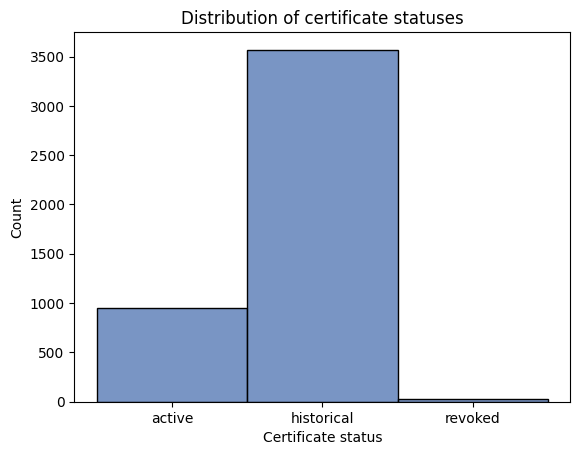

In [8]:
sns.histplot(data=df["status"])
plt.title("Distribution of certificate statuses")
plt.xlabel("Certificate status")
plt.show()

### Type distribution of certificates

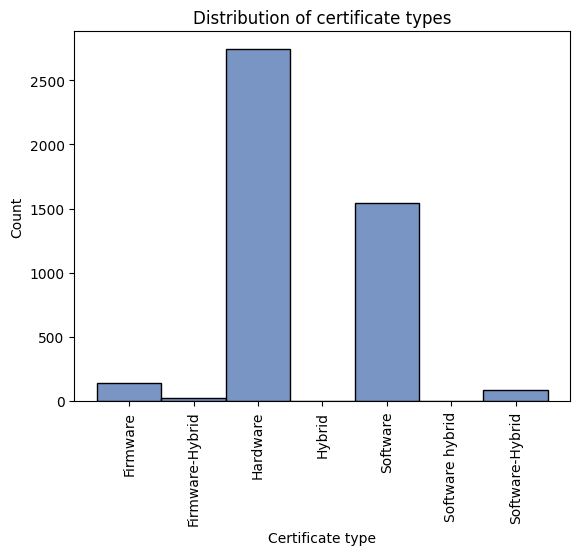

In [9]:
sns.histplot(data=df["type"])
plt.title("Distribution of certificate types")
plt.xlabel("Certificate type")
plt.xticks(rotation=90) 
plt.show()

### Standard distribution of certificates

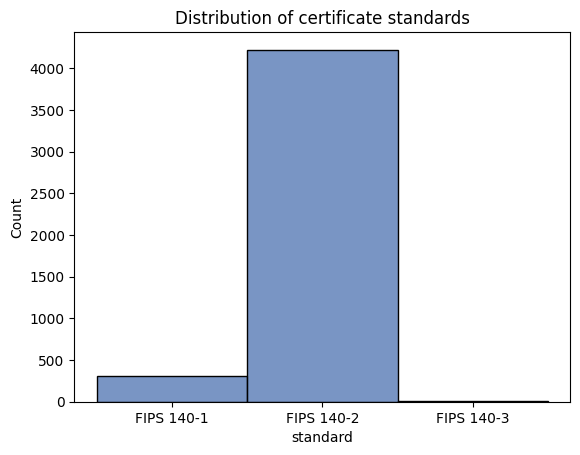

In [10]:
sns.histplot(data=df["standard"])
plt.title("Distribution of certificate standards")
plt.show()

### Distribution of embodiment in the dataset

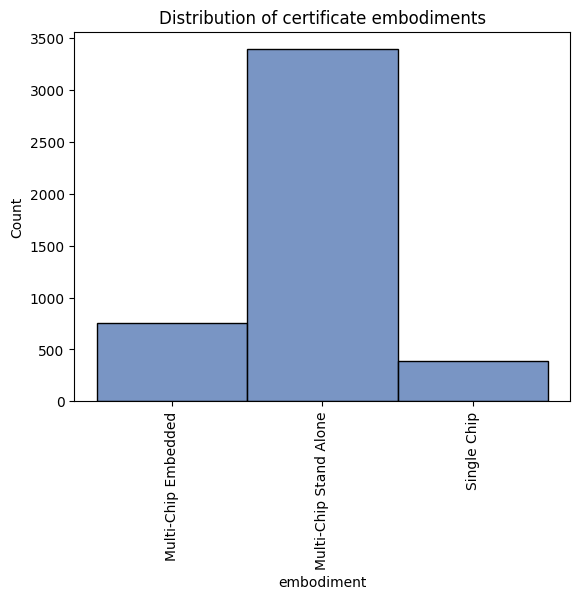

In [11]:
sns.histplot(data=df["embodiment"])
plt.title("Distribution of certificate embodiments")
plt.xticks(rotation=90) 
plt.show()

### Twenty most common CPEs in the dataset

In [12]:
cpe_certs_df: DataFrame = df[df["cpe_matches"].notna()]

print(f"Number of certificates with at least one CPE match: {cpe_certs_df.shape[0]}")

Number of certificates with at least one CPE match: 465


In [13]:
cpe_counter = Counter()
cpe_matches_per_cert: list[int] = []

for cpes in cpe_certs_df["cpe_matches"]:
    cpe_counter.update(cpes)
    cpe_matches_per_cert.append(len(cpes))

cpe_counter.most_common(20)

[('cpe:2.3:o:redhat:enterprise_linux:8.0:*:*:*:*:*:*:*', 19),
 ('cpe:2.3:o:redhat:enterprise_linux:8.0:*:*:*:-:*:*:*', 19),
 ('cpe:2.3:o:redhat:enterprise_linux:8.5.0:*:*:*:*:*:*:*', 19),
 ('cpe:2.3:o:redhat:enterprise_linux:8.6:*:*:*:*:*:*:*', 19),
 ('cpe:2.3:o:redhat:linux:8.0:*:*:*:*:*:*:*', 19),
 ('cpe:2.3:o:redhat:enterprise_linux:8.4:*:*:*:*:*:*:*', 19),
 ('cpe:2.3:o:redhat:enterprise_linux:8.1:*:*:*:*:*:*:*', 19),
 ('cpe:2.3:o:oracle:linux:7:-:*:*:*:*:*:*', 19),
 ('cpe:2.3:o:oracle:linux:7:0:*:*:*:*:*:*', 19),
 ('cpe:2.3:o:oracle:linux:7:2:*:*:*:*:*:*', 19),
 ('cpe:2.3:o:oracle:linux:7:1:*:*:*:*:*:*', 19),
 ('cpe:2.3:o:oracle:linux:7:3:*:*:*:*:*:*', 19),
 ('cpe:2.3:h:cisco:catalyst_6506-e:-:*:*:*:*:*:*:*', 15),
 ('cpe:2.3:h:cisco:catalyst_6509-e:-:*:*:*:*:*:*:*', 15),
 ('cpe:2.3:a:mcafee:network_security_platform:9.1:*:*:*:*:*:*:*', 12),
 ('cpe:2.3:h:juniper:mx240:-:*:*:*:*:*:*:*', 11),
 ('cpe:2.3:h:juniper:mx480:-:*:*:*:*:*:*:*', 11),
 ('cpe:2.3:h:juniper:mx960:-:*:*:*:*:*:*:*'

### CPE matches data extraction

Text(0.5, 1.0, 'Boxplot of total cpe matches per certificate')

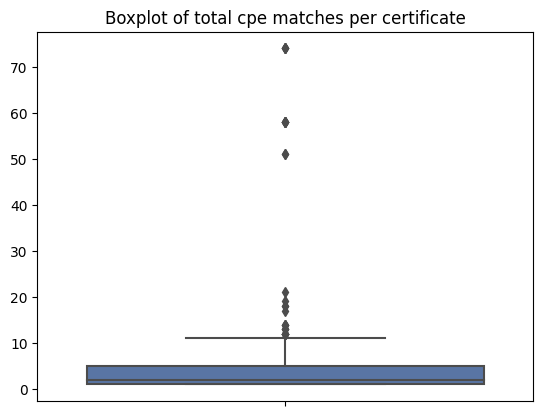

In [14]:
# Boxplot
sns.boxplot(y=cpe_matches_per_cert)
plt.title("Boxplot of total cpe matches per certificate")

In [15]:
# NOTE: We are calculating over "cpe_matches", since every cert has "verified_cpe_matches" equal to NaN
maximum_cpe_matches: int = max(cpe_matches_per_cert)
minimum_cpe_matches: int = min(cpe_matches_per_cert)
mean_cpe_matches: int = np.mean(cpe_matches_per_cert)
median_cpe_matches: int = np.median(cpe_matches_per_cert)
quantile_25 = np.percentile(cpe_matches_per_cert, 25)
quantile_75 = np.percentile(cpe_matches_per_cert, 75)
iqr = quantile_75 - quantile_25

print(f"Maximum cpe_matches: {maximum_cpe_matches}")
print(f"Minimum cpe_matches: {minimum_cpe_matches}")
print(f"Mean cpe_matches: {round(mean_cpe_matches, 2)}")
print(f"Median cpe_matches: {median_cpe_matches}")
print(f"First quartile: {quantile_25}")
print(f"Third quartile: {quantile_75}")
print(f"IQR: {iqr}")

Maximum cpe_matches: 74
Minimum cpe_matches: 1
Mean cpe_matches: 4.93
Median cpe_matches: 2.0
First quartile: 1.0
Third quartile: 5.0
IQR: 4.0


In [16]:
max_cpe_matches_df: DataFrame = cpe_certs_df[cpe_certs_df["cpe_matches"].apply(lambda x: len(x) == maximum_cpe_matches)]
max_cpe_matches_df

,cert_id,name,status,standard,type,level,embodiment,date_validation,date_sunset,algorithms,...,related_cves,module_directly_referenced_by,module_indirectly_referenced_by,module_directly_referencing,module_indirectly_referencing,policy_directly_referenced_by,policy_indirectly_referenced_by,policy_directly_referencing,policy_indirectly_referencing,year_from
dgst,,,,,,,,,,,,,,,,,,,,,
926a7fc32c08e491,989,Windows XP Enhanced Cryptographic Provider (RS...,historical,FIPS 140-2,Software,1.0,Multi-Chip Stand Alone,2008-07-24,NaT,"{Triple-DES MAC#675, AES#781, RNG#447, Triple-...",...,"{CVE-2014-0323, CVE-2011-1967, CVE-2012-0013, ...",NaN,NaN,NaN,NaN,{2009},{2009},NaN,NaN,2008
fe50b64954720ccb,990,Windows XP Enhanced DSS and Diffie-Hellman Cry...,historical,FIPS 140-2,Software,1.0,Multi-Chip Stand Alone,2008-07-24,NaT,"{RNG#448, DSA#292, Triple-DES#676, SHS#784, Tr...",...,"{CVE-2014-0323, CVE-2011-1967, CVE-2012-0013, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
749fc650cacb0f06,241,Kernel Mode Cryptographic Module for Windows XP,historical,FIPS 140-1,Software,1.0,Multi-Chip Stand Alone,2002-08-01,NaT,"{Triple-DES#16, DSA/SHA-1#35, HMAC-SHA-1#35}",...,"{CVE-2014-0323, CVE-2011-1967, CVE-2012-0013, ...",NaN,NaN,NaN,NaN,NaN,NaN,{106},{106},2002
6af1f692e9496c6d,240,DSS/Diffie-Hellman Enhanced Cryptographic Prov...,historical,FIPS 140-1,Software,1.0,Multi-Chip Stand Alone,2002-08-01,NaT,"{DSA/SHA-1#29, Triple-DES#16}",...,"{CVE-2014-0323, CVE-2011-1967, CVE-2012-0013, ...",NaN,NaN,NaN,NaN,{433},{433},NaN,NaN,2002


In [17]:
min_cpe_matches_df: DataFrame = cpe_certs_df[cpe_certs_df["cpe_matches"].apply(lambda x: len(x) == minimum_cpe_matches)]
min_cpe_matches_df

,cert_id,name,status,standard,type,level,embodiment,date_validation,date_sunset,algorithms,...,related_cves,module_directly_referenced_by,module_indirectly_referenced_by,module_directly_referencing,module_indirectly_referencing,policy_directly_referenced_by,policy_indirectly_referenced_by,policy_directly_referencing,policy_indirectly_referencing,year_from
dgst,,,,,,,,,,,,,,,,,,,,,
71cadd0c63e57249,4472,Amazon Linux 2 GnuTLS Cryptographic Module,active,FIPS 140-2,Software,1.0,Multi-Chip Stand Alone,2023-04-14,2025-04-19,"{RSA#C792, Triple-DES#C792, HMAC#C792, CVL#C79...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
9931f287c490c562,3618,Amazon Linux 2 Libgcrypt Cryptographic Module,active,FIPS 140-2,Software,1.0,Multi-Chip Stand Alone,2020-02-19,2025-02-18,"{SHS#C693, Triple-DES#C693, RSA#C693, HMAC#C69...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
03f65a290e11d786,3908,Juniper Networks NFX250 Network Services Platform,active,FIPS 140-2,Hardware,1.0,Multi-Chip Stand Alone,2021-04-23,2026-04-22,"{KTS#C1981, Triple-DES#C1979, SHS#C1983, Tripl...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
7119d5d9637ddeeb,3717,Juniper Networks NFX150 Network Services Platform,active,FIPS 140-2,Hardware,1.0,Multi-Chip Stand Alone,2020-09-28,2025-09-27,"{HMAC#C943, DRBG#C970, RSA#C947, ECDSA#C947, A...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
f36e412aea00d7c6,4519,Cisco Catalyst 9400 Series Switches,active,FIPS 140-2,Hardware,1.0,Multi-Chip Stand Alone,2023-05-11,2026-03-02,"{SHS#A1462, SHS#C431, RSA#C431, CVL#A1462, KAS...",...,NaN,NaN,NaN,{3637},{3637},NaN,NaN,{3637},{3637},2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9cbfc3c153a29e5c,2593,Network Security Platform Sensor NS-9300 S,historical,FIPS 140-2,Hardware,2.0,Multi-Chip Stand Alone,2016-03-29,NaT,"{RSA#1600, SHS#2923, SHS#2612, DRBG#649, RSA#1...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
1625f9db144171f7,1750,IDProtect Key with LASER PKI,historical,FIPS 140-2,Hardware,3.0,Single Chip,2012-07-17,NaT,"{ECDSA#214, DRBG#98, AES#1654, Triple-DES#1087...",...,{CVE-2019-15809},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
15bb14fd69723b98,3580,Network Security Platform Sensor NS9100 and NS...,historical,FIPS 140-2,Hardware,2.0,Multi-Chip Stand Alone,2019-12-09,NaT,"{CVL#C409, CVL#C410, DRBG#C409, RSA#2638, SHS#...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019


### Ten most common CVEs in the dataset

In [18]:
cve_certs_df: DataFrame = df[df["related_cves"].notna()]

print(f"Number of certificates with at least one CVE: {cve_certs_df.shape[0]}")

Number of certificates with at least one CVE: 220


In [19]:
cve_counter = Counter()

for cves in cve_certs_df["related_cves"]:
    cve_counter.update(cves)

cve_counter.most_common(10)

[('CVE-2016-7091', 49),
 ('CVE-1999-0894', 45),
 ('CVE-2007-3103', 45),
 ('CVE-2001-0889', 45),
 ('CVE-2001-0690', 45),
 ('CVE-2000-1207', 45),
 ('CVE-2000-0017', 45),
 ('CVE-1999-1288', 45),
 ('CVE-1999-0798', 45),
 ('CVE-2000-0701', 45)]

### Ten most common crypto algorithms used

In [20]:
crypto_algo_counter = Counter()

for algorithms in df["algorithms"]:
    crypto_algo_counter.update(algorithms)

crypto_algo_counter.most_common(10)

[('RSA#1', 180),
 ('Triple-DES#34', 45),
 ('RSA#1166', 35),
 ('SHS#1954', 35),
 ('DSA#709', 35),
 ('Triple-DES#1420', 35),
 ('ECDSA#368', 35),
 ('HMAC#1391', 35),
 ('AES#2273', 35),
 ('DRBG#281', 35)]

## Analysis of FIPS references

In [21]:
refs_columns: list[str] = [
    "cert_id", 
    "status",
    "standard",
    "type",
    "level",
    "embodiment",
    "module_directly_referenced_by", 
    "module_indirectly_referenced_by",
    "module_directly_referencing",
    "module_indirectly_referencing",
    "policy_directly_referenced_by",
    "policy_indirectly_referenced_by",
    "policy_directly_referencing",
    "policy_indirectly_referencing",
]

### References EDA

In [22]:
refs_df = df[refs_columns]

In [23]:
refs_direct_eda_df = refs_df[refs_df["module_directly_referencing"].notna()]
refs_indirect_eda_df = refs_df[refs_df["module_indirectly_referencing"].notna()]

In [24]:
def process_direct_references(df: DataFrame, func: Callable[[list[int]], float]) -> float:
    return func([len(refs) for refs in df["module_directly_referencing"]])

def process_indirect_references(df: DataFrame, func: Callable[[list[int]], float]) -> float:
    return func([len(refs) for refs in df["module_indirectly_referencing"]])

#### Direct

In [25]:
total_directly_referencing_certs: int = refs_direct_eda_df.shape[0]
total_direct_references: int = process_direct_references(refs_direct_eda_df, sum)
maximum_direct_references: int = process_direct_references(refs_direct_eda_df, max)
minimum_direct_references: int = process_direct_references(refs_direct_eda_df, min)
mean_direct_references: float = round(process_direct_references(refs_direct_eda_df, np.mean), 2)
median_direct_references: float = process_direct_references(refs_direct_eda_df, np.median)

print(f"Total directly referencing certs: {total_directly_referencing_certs}")
print(f"Total direct references among all certs: {total_direct_references}")
print(f"Maximum directly referenced certs at once: {maximum_direct_references}")
print(f"Minimum directly referenced certs at once: {minimum_direct_references}")
print(f"Mean of all direct references: {mean_direct_references}")
print(f"Median of all direct references: {median_direct_references}")

Total directly referencing certs: 474
Total direct references among all certs: 627
Maximum directly referenced certs at once: 8
Minimum directly referenced certs at once: 1
Mean of all direct references: 1.32
Median of all direct references: 1.0


#### Indirect

In [26]:
total_indirectly_referencing_certs: int = refs_indirect_eda_df.shape[0]
total_indirect_references: int = process_indirect_references(refs_indirect_eda_df, sum)
maximum_indirect_references: int = process_indirect_references(refs_indirect_eda_df, max)
minimum_indirect_references: int = process_indirect_references(refs_indirect_eda_df, min)
mean_indirect_references: float = round(process_indirect_references(refs_indirect_eda_df, np.mean), 2)
median_indirect_references: float = process_indirect_references(refs_indirect_eda_df, np.median)

print(f"Total indirectly referencing certs: {total_indirectly_referencing_certs}")
print(f"Total indirect references among all certs: {total_indirect_references}")
print(f"Maximum indirectly referenced certs at once: {maximum_indirect_references}")
print(f"Minimum indirectly referenced certs at once: {minimum_indirect_references}")
print(f"Mean of all indirect references: {mean_indirect_references}")
print(f"Median of all indirect references: {median_indirect_references}")

Total indirectly referencing certs: 474
Total indirect references among all certs: 1044
Maximum indirectly referenced certs at once: 27
Minimum indirectly referenced certs at once: 1
Mean of all indirect references: 2.2
Median of all indirect references: 1.0


### Active certificates which reference at least one historical cert (=module refs)

In [27]:
def get_cert_status(dataset: DataFrame, cert_id: int) -> str | None:
    sub_df = refs_df[refs_df["cert_id"] == int(cert_id)]
    
    if sub_df.shape[0] == 0:  # Certificate is not in the dataset
        print(f"Cert ID: {cert_id} not in dataset")
        return None
    
    if sub_df.shape[0] > 1:  # There are more than one occurence with same ID
        print(f"Error Cert ID: {cert_id} has {sub_df.shape[0]} occurrences.")
        return None
    
    return sub_df.iloc[0]["status"]

def is_cert_referencing_historical_cert(dataset: DataFrame, cert_ids: set[int]) -> bool:
    return "historical" in [get_cert_status(dataset, cert_id) for cert_id in cert_ids]

In [28]:
active_certs_referencing_historical: list[int] = []
active_referencing_certs: DataFrame = refs_df[(refs_df["status"] == "active") & (refs_df["module_directly_referencing"].notna())]

for _, rows in active_referencing_certs.iterrows():
    referencing_ids = rows["module_directly_referencing"]
        
    if is_cert_referencing_historical_cert(refs_df, referencing_ids):
        active_certs_referencing_historical.append(rows.cert_id)

print(f"Total active certificates referencing at least one historical: {len(active_certs_referencing_historical)}")
print(f"Total active certificates referencing at least one certificate: {len(active_referencing_certs)}")
print(f"Hit ratio: {len(active_certs_referencing_historical) / len(active_referencing_certs)}")

Total active certificates referencing at least one historical: 12
Total active certificates referencing at least one certificate: 129
Hit ratio: 0.09302325581395349


### Certificates with higher levels referencing certficates with lower levels

In [29]:
referencing_certs: DataFrame = refs_df[refs_df["module_directly_referencing"].notna()]

In [30]:
def get_cert_level(dataset: DataFrame, cert_id) -> int:
    sub_df = refs_df[refs_df["cert_id"] == int(cert_id)]
    return int(sub_df.iloc[0]["level"])
    

def compare_levels(dataset: DataFrame, cert_ids: set[int], compare_to_level: int) -> int:
    is_referencing_any_lower_level = [get_cert_level(dataset, cert_id) < compare_to_level for cert_id in cert_ids]
    return any(is_referencing_any_lower_level)

In [31]:
def get_certs_referencing_lower_level(refs_df: DataFrame, referencing_certs: DataFrame, compare_level: int) -> list[int]:
    cert_ids = []
    
    for _, rows in referencing_certs.iterrows():
        referencing_ids = rows["module_directly_referencing"]
        if compare_levels(refs_df, referencing_ids, compare_level):
            cert_ids.append(rows.cert_id)

    return cert_ids

#### Level 2 referencing at least one certificate of level 1

In [33]:
compare_level: int = 2
level2_ref_certs = referencing_certs[referencing_certs["level"] == compare_level]
certificates_referencing_lower_level: list[int] = get_certs_referencing_lower_level(refs_df, level2_ref_certs, compare_level)
ratio: float = len(certificates_referencing_lower_level) / level2_ref_certs.shape[0]
print(f"Total amount of certificates with level {compare_level} referencing at least one certificate: {level2_ref_certs.shape[0]}")
print(f"Total amount of certicates with reference at least one certificate with lower level: {len(certificates_referencing_lower_level)}")
print(f"Hit ratio: {round(ratio, 2)}")

Total amount of certificates with level 2 referencing at least one certificate: 40
Total amount of certicates with reference at least one certificate with lower level: 16
Hit ratio: 0.4


#### Level 3 referencing at least one certificate of level 1 or 2

In [35]:
compare_level: int = 3
level3_ref_certs = referencing_certs[referencing_certs["level"] == compare_level]
certificates_referencing_lower_level: list[int] = get_certs_referencing_lower_level(refs_df, level3_ref_certs, compare_level)
ratio: float = len(certificates_referencing_lower_level) / level3_ref_certs.shape[0]
print(f"Total amount of certificates with level {compare_level} referencing at least one certificate: {level3_ref_certs.shape[0]}")
print(f"Total amount of certicates with reference at least one certificate with lower level: {len(certificates_referencing_lower_level)}")
print(f"Hit ratio: {round(ratio, 2)}")

Total amount of certificates with level 3 referencing at least one certificate: 27
Total amount of certicates with reference at least one certificate with lower level: 1
Hit ratio: 0.04


#### Level 4 referencing at least one certificate of level 1, 2 or 3

In [36]:
level4_ref_certs = referencing_certs[referencing_certs["level"] == 4].shape[0]
total_level4_certs: int = df[df["level"] == 4].shape[0]
    
# TODO - Could be temporary due to constantly updated dataset
print(f"Out of {total_level4_certs} references at least one certificates only {level4_ref_certs}")

Out of 26 references at least one certificates only 0


### Distribution of references among embodiments

In [45]:
def get_cert_embodiment(df: DataFrame, cert_id: str) -> str:
    sub_df = df[refs_df["cert_id"] == int(cert_id)]
    return sub_df.iloc[0]["embodiment"]

# TODO - pass ref_df as argument, not as global var
def get_embodiment_references(embodiment: str) -> dict[str, int]:
    result = {}
    sub_df = refs_df[(refs_df["embodiment"] == embodiment) & (refs_df["module_directly_referencing"].notna())]
    
    for references in sub_df["module_directly_referencing"]:
        for cert_id in references:
            referenced_embodiment: str = get_cert_embodiment(refs_df, cert_id)
            # TODO - here is fuck up imo
            result[referenced_embodiment] = result.get(referenced_embodiment, 0) + 1
    
    return result

In [46]:
final_embodiment_statistics: dict[str, dict[str, int]] = {} 

for embodiment in refs_df["embodiment"].unique():
    final_embodiment_statistics[embodiment] = get_embodiment_references(embodiment)

pprint(final_embodiment_statistics)

{'Multi-Chip Embedded': {'Multi-Chip Embedded': 13, 'Single Chip': 2},
 'Multi-Chip Stand Alone': {'Multi-Chip Embedded': 7,
                            'Multi-Chip Stand Alone': 546,
                            'Single Chip': 28},
 'Single Chip': {'Multi-Chip Embedded': 2,
                 'Multi-Chip Stand Alone': 1,
                 'Single Chip': 28}}


### Distribution of references among types

In [53]:
# TODO - refactor into one generic function later
def get_cert_type(df: DataFrame, cert_id: str) -> str:
    sub_df = df[df["cert_id"] == int(cert_id)]
    return sub_df.iloc[0]["type"]

def get_type_references(refs_df: DataFrame, cert_type: str) -> dict[str, int]:
    result = {}
    sub_df = refs_df[(refs_df["type"] == cert_type) & (refs_df["module_directly_referencing"].notna())]
    
    for references in sub_df["module_directly_referencing"]:
        for cert_id in references:
            referenced_type: str = get_cert_type(refs_df, cert_id)
            result[referenced_type] =result.get(referenced_type, 0) + 1
    
    return result

In [54]:
final_type_statistics: dict[str, dict[str, int]] = {}

for cert_type in refs_df["type"].unique():
    final_type_statistics[cert_type] = get_type_references(refs_df, cert_type)

pprint(final_type_statistics)

{'Firmware': {'Firmware': 1, 'Hardware': 1},
 'Firmware-Hybrid': {'Hardware': 2},
 'Hardware': {'Firmware': 2,
              'Firmware-Hybrid': 2,
              'Hardware': 76,
              'Software': 9},
 'Hybrid': {},
 'Software': {'Firmware': 1,
              'Hardware': 1,
              'Software': 502,
              'Software-Hybrid': 3},
 'Software hybrid': {},
 'Software-Hybrid': {'Hardware': 5, 'Software': 6, 'Software-Hybrid': 16}}
